In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/processed/tlt_nav_basis.csv', parse_dates=['DATE']).set_index('DATE')
df.head()

,etf_open,etf_high,etf_low,etf_close,etf_volume,nav_proxy,basis,basis_bps
DATE,,,,,,,,
2020-11-09,134.091588,134.246333,132.939558,134.168961,23245000,67.899668,0.975988,9759.884501
2020-11-10,133.223321,133.954081,133.068563,133.395264,12561000,67.662435,0.971482,9714.818674
2020-11-11,133.274827,134.065774,133.231838,133.876633,5888200,NaN,NaN,NaN
2020-11-12,134.925535,136.180729,134.727801,136.154938,15999700,68.977554,0.973902,9739.020785
2020-11-13,136.146338,136.266700,135.759464,135.974396,7344600,68.856949,0.974737,9747.374450


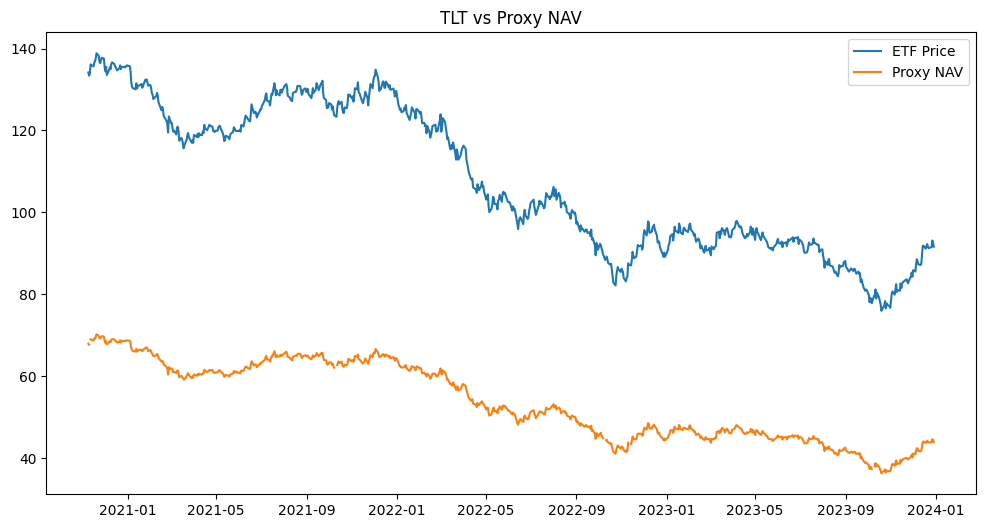

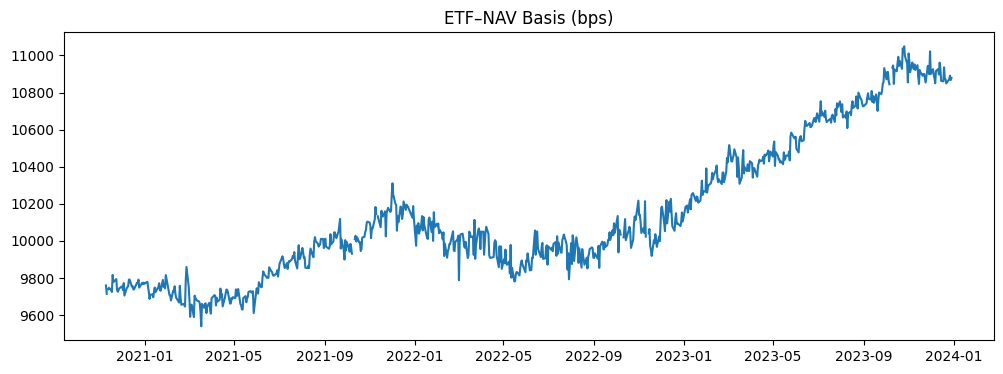

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['etf_close'], label='ETF Price')
plt.plot(df.index, df['nav_proxy'], label='Proxy NAV')
plt.title('TLT vs Proxy NAV')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df.index, df['basis']*1e4)
plt.title('ETF–NAV Basis (bps)')
plt.show()

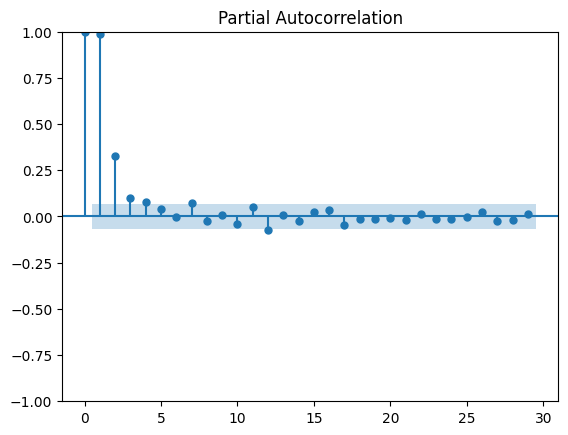

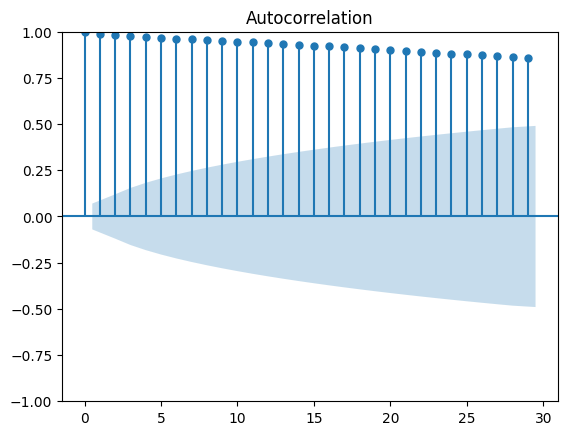

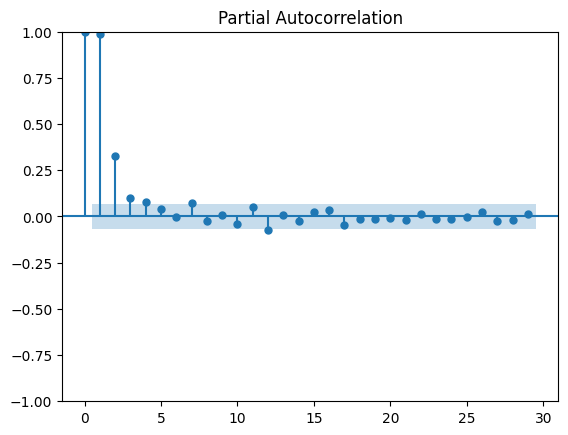

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['basis'].dropna()); plot_pacf(df['basis'].dropna())

In [9]:
import numpy as np

# --- 1️⃣ Daily volatility (realised)
df['ret'] = df['etf_close'].pct_change()
df['vol_5d'] = df['ret'].rolling(5).std() * np.sqrt(252) * 100  # annualised %
df['vol_20d'] = df['ret'].rolling(20).std() * np.sqrt(252) * 100

# --- 2️⃣ Bid–ask spread (bps)
# If you have bid/ask columns:
# df['spread_bps'] = ((df['ask'] - df['bid']) / ((df['ask'] + df['bid'])/2)) * 1e4
# If not, proxy it inversely by liquidity from volume:
df['spread_proxy_bps'] = (1 / df['etf_volume']) * 1e6   # larger volume → tighter spread

# --- 3️⃣ Turnover & volume z-score
df['volume_z'] = (df['etf_volume'] - df['etf_volume'].rolling(60).mean()) / df['etf_volume'].rolling(60).std()

df[['vol_5d','spread_proxy_bps','volume_z']].tail()

,vol_5d,spread_proxy_bps,volume_z
DATE,,,
2023-12-22,10.947197,0.034195,-1.343170
2023-12-26,9.402750,0.041632,-1.598796
2023-12-27,15.360311,0.022181,-0.349298
2023-12-28,16.542669,0.027614,-0.846498
2023-12-29,17.332605,0.024029,-0.508510


In [10]:
corr = df[['basis','vol_5d','spread_proxy_bps','volume_z']].corr()
print(corr['basis'])

basis               1.000000
vol_5d              0.224956
spread_proxy_bps   -0.560903
volume_z            0.119860
Name: basis, dtype: float64


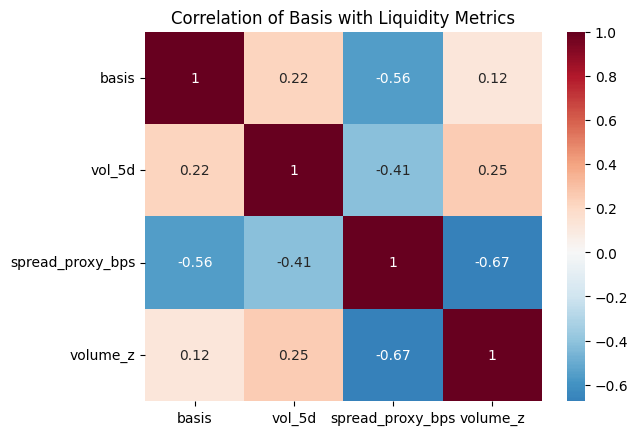

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df[['basis','vol_5d','spread_proxy_bps','volume_z']].corr(),
            annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation of Basis with Liquidity Metrics')
plt.show()

Explortatory data analysis has confirmed that basis reacts to liquidity due to a positive corr with volume_z and a negative correlation with spread_proxy_bps